**<h1>DATA ANALYSIS ON THE FINANCIAL STATEMENT DATA SETS</h1>**
Using data from https://www.sec.gov/data-research/sec-markets-data/financial-statement-data-sets

It extracts the choosen Statement report of a choosen Company, saving it as a parquet file (optional) and plots choosen data (optional) 

NB: In this version it is possible to download the file directly from the program (choose in the beginning the file that you want)

In [1]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from zipfile import ZipFile
import os
import io
import requests

In [2]:
# YEAR AND DATA SELECTION
year_dropdown = widgets.Dropdown(
    options=[2009 + i for i in range(16)],
    description='Year:',
    layout=widgets.Layout(width='200px', height='50px')
)

quarter_dropdown = widgets.Dropdown(
    options=['q1','q2','q3','q4'],
    description='Quarter:',
    layout=widgets.Layout(width='200px', height='50px')
)

# Display the dropdown widget
display(year_dropdown, quarter_dropdown)

Dropdown(description='Year:', layout=Layout(height='50px', width='200px'), options=(2009, 2010, 2011, 2012, 20…

Dropdown(description='Quarter:', layout=Layout(height='50px', width='200px'), options=('q1', 'q2', 'q3', 'q4')…

In [3]:
#----------- Download from website ----------------------------------------------------------------
folder = str(year_dropdown.value) + quarter_dropdown.value # folder of the zip file choosen

# Only downloads if files don't exist already
if os.path.exists(folder):
    print(f'Data already downloaded and extracted to {folder}.') 

else:
    output_path = folder + '.zip' # Path where the zip file will be saved
    # print(folder)
    url = 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/' #url of data
    url += output_path
    # print(url)

    # Headers to mimic a browser request
    headers = {
        'Accept': 'image/avif,image/webp,image/apng,image/svg+xml,image/*,*/*;q=0.8',
        'Accept-Encoding': 'gzip, deflate, br, zstd',
        'Accept-Language': 'pt-PT,pt;q=0.9,pt-BR;q=0.8,en;q=0.7,en-US;q=0.6,en-GB;q=0.5,it;q=0.4',
        'Referer': 'https://www.sec.gov/data-research/sec-markets-data/financial-statement-data-sets',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36 Edg/133.0.0.0'
    }

    # Send a GET request to the URL with headers
    response = requests.get(url, headers=headers)

    if response.status_code == 200: # 200 is HTTP code for success
        with open(output_path, 'wb') as file: # Write the content of the response to a file
            file.write(response.content)
        print(f"File downloaded successfully and saved as {output_path}")
    else: # HTTP response code 3xx, 4xx means error
        print(f"Failed to download file. Status code: {response.status_code}. Check headers and/or add cookies!")


    #-----------------Extract the zip file----------------------------------------------------
    if response.status_code == 200:
        if not os.path.exists(folder): # Create new directory if it doesn't exist
            os.makedirs(folder)

        with ZipFile(output_path, 'r') as zip_ref: # Open the zip file in read mode
            zip_ref.extractall(folder)

        print(f'Files extracted to: {folder}')

print('Loading data...')
sub = pd.read_csv(folder+'/sub.txt',delimiter='\t')
tag = pd.read_csv(folder+'/tag.txt',delimiter='\t')
num = pd.read_csv(folder+'/num.txt',delimiter='\t')
pre = pd.read_csv(folder+'/pre.txt',delimiter='\t')
print('Done')

File downloaded successfully and saved as 2024q4.zip
Files extracted to: 2024q4
Loading data...
Done


Select __Company__ and __Statement type__ here:

In [4]:
# COMPANIES AND REPORT SELECTION
sub_name = sub['name'].sort_values()
sub_name = sub_name.drop_duplicates(keep='first') # list of all companies (only the first appearence)
Comp_dropdown = widgets.Dropdown(
    options=sub_name.tolist(),
    description='Company:',
    layout=widgets.Layout(width='400px', height='50px')
)

report_df = pd.DataFrame({  'Balance Sheet': ['BS'], 'Income Statement': ['IS'], 
                            'Cash Flows': ['CF'], 'Equity': ['EQ'],
                            'Comprehensive Income': ['CI'], 'Unclassifiable Statement': ['UN']})
report_dropdown = widgets.Dropdown(
    options=report_df.keys().to_list(),
    description='Statement:',
    layout=widgets.Layout(width='400px', height='50px')
)

# Display the dropdown widget
display(Comp_dropdown, report_dropdown)

# del(sub_name)


Dropdown(description='Company:', layout=Layout(height='50px', width='400px'), options=('1 800 FLOWERS COM INC'…

Dropdown(description='Statement:', layout=Layout(height='50px', width='400px'), options=('Balance Sheet', 'Inc…

In [5]:
#----------------- DATA FILTERING AND PIVOTING -----------------------------------------------------
cik = sub[sub['name'] == Comp_dropdown.value]['cik'].values[0] # cik correspondig to user_CompName [value]
adsh_cik = sub[sub['cik'] == cik]['adsh'] # selection of adsh values according with cik choosen
pre_user = pre[(pre['adsh'].isin(adsh_cik)) & (pre['stmt'] == report_df[report_dropdown.value][0])] # pre filtered with user data (Company name and Report type)
num_user = num[(num['adsh'].isin(adsh_cik)) & (num['tag'].isin(pre_user['tag']))][['adsh','ddate','tag','value','uom']] # num filtered with user data

if num_user.empty:
        print(f'\n{Comp_dropdown.value} has no {report_dropdown.value} statement in this quarter.')

else:
        # ----------------------------------------- TABLE 1 ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        num_user['ddate'] = pd.to_datetime(num_user['ddate'],format='%Y%m%d').dt.strftime('%Y-%m-%d') # conversion of ddate column to date format
        num_user = num_user.sort_values(by=['uom','ddate','tag']).reset_index(drop=True) # sorting by value type (uom) ddate and tag
        # num_user = num_user.dropna() # removing "Missing values" rows

        print(f'\nCompany: {Comp_dropdown.value} \n-> CIK: {cik}; \n-> From: {sub[sub['cik']==cik]['countryba'].values[0]}, {sub[sub['cik']==cik]['stprba'].values[0]}, {sub[sub['cik']==cik]['cityba'].values[0]}')
        print(f'\nTable 1: Data of the {report_dropdown.value} statement, ordered by uom, date and tag (respectively):')
        display(num_user[['ddate','tag','value','uom']].sort_values(by=['tag']).reset_index(drop=True))
        # display(num_user)

        # ----------------------------------------- TABLE 2 (PIVOT) ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        pre_num_user = pd.merge(pre_user,num_user)
        pre_num_user = pre_num_user.sort_values(by=['uom','ddate','tag']).reset_index(drop=True) # sorting by value type (uom) ddate and tag
        pre_num_user = pre_num_user.dropna() # removing "Missing values" rows

        table_xpto = pre_num_user.pivot_table(index=['tag','plabel','uom'], columns='ddate', values='value', aggfunc='sum') #pivots the pre_num_user table (transposes the ddate column to the 1st row); also sums all values with same label and date
        table_xpto = table_xpto.sort_values(by=['uom','tag']).reset_index()
        # Compute the sum of all values on the same row (exlcluding first three columns) and add it as a new column
        table_xpto['Total Value'] = table_xpto[[col for col in table_xpto.columns \
                                                if col not in ['plabel','tag','uom']]].sum(axis=1)
        # Reorder columns to place 'Total Value' in the 4th column
        cols = list(table_xpto.columns) # list of columns
        cols.insert(3, cols.pop(cols.index('Total Value'))) # Finds index of Total Value, pops it from cols, and puts it index 3
        table_xpto = table_xpto[cols]         

        print(f'\nTable 2: Total of each plabel (tag) {report_dropdown.value} statement (also sorted by uom):')
        display(table_xpto)

        # table_xpto2 = pre_num_user.pivot_table(index=['tag','plabel','uom'], columns='ddate', values='value') 
        # table_xpto2 = table_xpto2.sort_values(by=['uom','tag']).reset_index()
        # table_xpto2['Total Value'] = table_xpto2[[col for col in table_xpto2.columns \
        #                                         if col not in ['plabel','tag','uom']]].sum(axis=1)
        # cols = list(table_xpto2.columns) # list of columns
        # cols.insert(3, cols.pop(cols.index('Total Value'))) # Finds index of Total Value, pops it from cols, and puts it index 3
        # table_xpto2 = table_xpto2[cols]
        # display(table_xpto2)


#-------------- SAVE FILTERED DATA W/ PIVOTING (table_xpto) as Parquet file ----------------------------------

def save_data(b):
        save_dir = os.path.join(os.getcwd(), f'{Comp_dropdown.value}'+'-'+f'{report_dropdown.value}')
        table_xpto.to_parquet(save_dir, engine='pyarrow', compression='snappy')
        print(f'\nTable 2 saved as Parquet file at: {save_dir}')
        # del(save_dir)

save_button = widgets.Button(description="Save Data") 
save_button.on_click(save_data)
display(save_button)



Company: APPLE INC 
-> CIK: 320193; 
-> From: US, CA, CUPERTINO

Table 1: Data of the Balance Sheet statement, ordered by uom, date and tag (respectively):


,ddate,tag,value,uom
0,2024-09-30,AccountsPayableCurrent,6.896000e+10,USD
1,2023-09-30,AccountsPayableCurrent,6.261100e+10,USD
2,2024-09-30,AccountsReceivableNetCurrent,3.341000e+10,USD
3,2023-09-30,AccountsReceivableNetCurrent,2.950800e+10,USD
4,2024-09-30,AccumulatedOtherComprehensiveIncomeLossNetOfTax,-7.172000e+09,USD
...,...,...,...,...
157,2024-09-30,StockholdersEquity,5.695000e+10,USD
158,2023-09-30,StockholdersEquity,-2.140000e+08,USD
159,2023-09-30,StockholdersEquity,7.381200e+10,USD
160,2023-09-30,StockholdersEquity,6.214600e+10,USD



Table 2: Total of each plabel (tag) Balance Sheet statement (also sorted by uom):


ddate,tag,plabel,uom,Total Value,2021-09-30,2022-09-30,2023-09-30,2024-09-30
0,AccountsPayableCurrent,Accounts payable,USD,1.315710e+11,NaN,NaN,6.261100e+10,6.896000e+10
1,AccountsReceivableNetCurrent,"Accounts receivable, net",USD,6.291800e+10,NaN,NaN,2.950800e+10,3.341000e+10
2,AccumulatedOtherComprehensiveIncomeLossNetOfTax,Accumulated other comprehensive loss,USD,-1.862400e+10,NaN,NaN,-1.145200e+10,-7.172000e+09
3,Assets,Total assets,USD,7.175630e+11,NaN,NaN,3.525830e+11,3.649800e+11
4,AssetsCurrent,Total current assets,USD,2.965530e+11,NaN,NaN,1.435660e+11,1.529870e+11
5,AssetsNoncurrent,Total non-current assets,USD,4.210100e+11,NaN,NaN,2.090170e+11,2.119930e+11
6,CashAndCashEquivalentsAtCarryingValue,Cash and cash equivalents,USD,1.241660e+11,NaN,NaN,6.153600e+10,6.263000e+10
7,CommercialPaper,Commercial paper,USD,3.195200e+10,NaN,NaN,1.198500e+10,1.996700e+10
8,CommonStockParOrStatedValuePerShare,"Common stock, par value (in dollars per share)",USD,0.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00
9,CommonStocksIncludingAdditionalPaidInCapital,"Common stock and additional paid-in capital, $...",USD,1.570880e+11,NaN,NaN,7.381200e+10,8.327600e+10


Button(description='Save Data', style=ButtonStyle())

In [6]:

#--------------- PROOF THAT THE FOUR MERGES ARE EQUAL AFTER FILTERING -------------------------
# pre_num_user2 = pd.merge(pre_user,num_user, on=['adsh','tag'])
# pre_num_user3 = pd.merge(pre_user,num_user, on=['adsh','tag'],how='left')
# pre_num_user4 = pd.merge(pre_user,num_user, on=['adsh','tag'],how='right')
# pre_num_user_list = [pre_num_user1, pre_num_user2, pre_num_user3, pre_num_user4]
# for i in range(4):
#     pre_num_user_list[i] = pre_num_user_list[i].sort_values(by=['uom','ddate','tag']).reset_index(drop=True)
# i=0
# l=[]
# for data in pre_num_user_list:
#     i+=1
#     for data_comp in pre_num_user_list[i:]:
#         l.append(data.equals(data_comp))
# print(l)

Choose __uom__ and __tag__ to plot data from __Table 2__ (only it is ploted data with at least 2 points):

Dropdown(description='Value type:', layout=Layout(height='50px', width='400px'), options=('USD', 'shares'), va…

Dropdown(description='Tag:', index=27, layout=Layout(height='50px', width='400px'), options=('AccountsPayableC…

Button(description='Click to Plot', style=ButtonStyle())

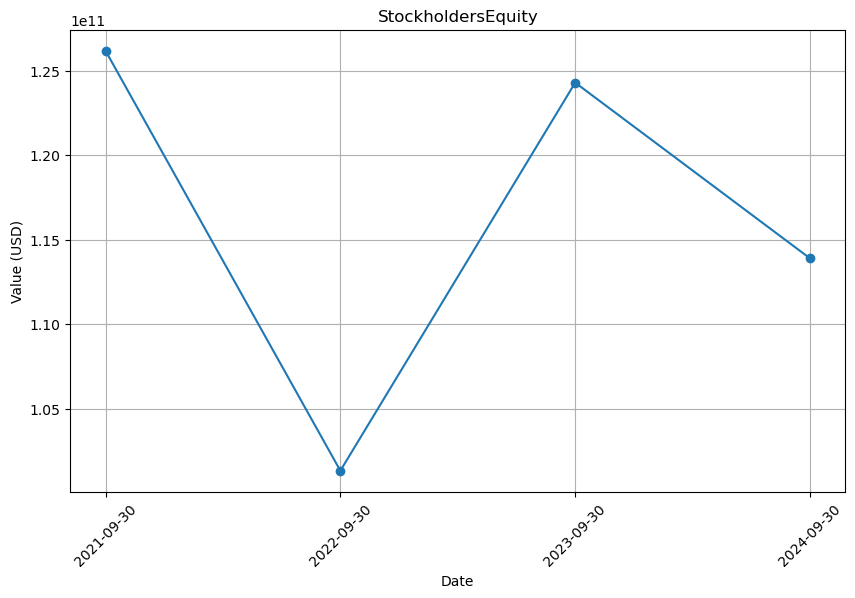

In [ ]:
# DATA SELECTION FOR PLOTTING
uom_dropdown = widgets.Dropdown(
    options=table_xpto['uom'].drop_duplicates(keep='first').to_list(),
    description='Value type:',
    layout=widgets.Layout(width='400px', height='50px')
)

tag_dropdown = widgets.Dropdown(
    options=[],                     # !!! needs to start empty
    description='Tag:',
    layout=widgets.Layout(width='400px', height='50px')
)

# Function to update the tag dropdown based on the selected uom
def update_tag(change):
    selected_uom = change['new']
    tag_dropdown.options = table_xpto[table_xpto['uom']==uom_dropdown.value]['tag'].drop_duplicates(keep='first')

uom_dropdown.observe(update_tag, names='value')
tag_dropdown.options = table_xpto[table_xpto['uom']==uom_dropdown.value]['tag'].drop_duplicates(keep='first') #initializes with values of first uom


# Define the function to plot the data
def plot_data(b):
    clear_output(wait=True) # Clear the output of the cell
    display(uom_dropdown, tag_dropdown, plot_button) # Display the buttons again after plotting

    tag_data = table_xpto[table_xpto['tag'] == tag_dropdown.value]

    dates = tag_data.columns[4:]  # Skip the first four columns
    values = tag_data.iloc[0, 4:] # Values 
    # print(values)

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(dates, values, marker='o', linestyle='-')
    plt.title(f'{tag_dropdown.value}')
    plt.xlabel('Date')
    plt.ylabel(f'Value ({uom_dropdown.value})')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Create a button widget
plot_button = widgets.Button(description="Click to Plot")

# Add the function to the button's 'on_click' event
plot_button.on_click(plot_data)

display(uom_dropdown, tag_dropdown)
display(plot_button)
